In [1]:
# # Fraud Diffusion Model - Hyperparameter Tuning
# 
# This notebook systematically tests different loss weight combinations for the diffusion model.

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import joblib
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
#############################################
# Step 1: Data and Artifact Loading
#############################################
# Load preprocessed data
X_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\y_train.csv")

# Load preprocessing artifacts
scaler = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_vocab.pkl")
cat_mapping = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_mapping.pkl")

# Feature setup
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
eng_indices = [numeric_features.index(f) for f in ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']]

# Filter fraud samples
fraud_mask = (y_train_df.iloc[:, 0] == 1)
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values
X_nonfraud_num = X_train_df[numeric_features].loc[~fraud_mask].values

# Engineered feature constraints
eng_min = torch.tensor(np.min(X_train_num[:, eng_indices], axis=0), 
                      dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')
eng_max = torch.tensor(np.max(X_train_num[:, eng_indices], axis=0),
                     dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#############################################
# Step 2: Dataset and Model Setup
#############################################
class FraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self): return len(self.num_data)
    def __getitem__(self, idx): return self.num_data[idx], self.cat_data[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_train = 800
beta = torch.linspace(1e-4, 0.02, T_train).to(device)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)

In [4]:
device

device(type='cuda')

In [5]:
#############################################
# Step 3: Model Architecture
#############################################
class CombinedNoisePredictor(nn.Module):
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=2, hidden_dim=256):
        super().__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab_size in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab_size, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(num_input_dim + cat_total_dim + 1, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, num_input_dim)  # Only predict numeric noise
        )
        
    def forward(self, x_num, x_cat, t):
        embeds = [self.embeddings[col](x_cat[:,i]) for i,col in enumerate(self.embeddings)]
        x = torch.cat([x_num, *embeds, (t.float()/T_train).unsqueeze(1)], dim=1)
        return self.mlp(x)

In [9]:
#############################################
# Step 4: Core Training Functions
#############################################
def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def train_model(config, train_loader, num_epochs=150):
    model = CombinedNoisePredictor(
        num_input_dim=len(numeric_features),
        cat_vocab_sizes={col: cat_vocab[col] for col in cat_features}
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    mu_nf = X_nonfraud_tensor.mean(dim=0)
    sigma_nf = X_nonfraud_tensor.std(dim=0) + 1e-5
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_num, x_cat in train_loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            t = torch.randint(0, T_train, (x_num.size(0),), device=device)
            
            # Forward diffusion and prediction
            x_t, noise = forward_diffusion(x_num, t)
            pred_noise = model(x_t, x_cat, t)
            
            # Loss calculations
            mse_loss = F.mse_loss(pred_noise, noise)
            
            z = (pred_noise - mu_nf)/sigma_nf
            prior_loss = (1 - 2*(1 - torch.distributions.Normal(0,1).cdf(torch.abs(z)))).mean()
            
            x0_est = (x_t - torch.sqrt(1-alpha_hat[t]).unsqueeze(1)*pred_noise)/torch.sqrt(alpha_hat[t]).unsqueeze(1)
            rand_idx = torch.randint(0, len(X_nonfraud_tensor), (x_num.size(0),))
            triplet_loss = F.relu(F.pairwise_distance(x0_est, x_num) - 
                                 F.pairwise_distance(x0_est, X_nonfraud_tensor[rand_idx]) + 1).mean()
            
            eng_loss = torch.mean(F.relu(eng_min - x0_est[:,eng_indices]) + 
                                F.relu(x0_est[:,eng_indices] - eng_max))
            
            total_loss += (mse_loss + config['w1']*prior_loss + 
                         config['w2']*triplet_loss + config['lambda_eng']*eng_loss).item()
            
            optimizer.zero_grad()
            (mse_loss + config['w1']*prior_loss + config['w2']*triplet_loss + config['lambda_eng']*eng_loss).backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss/len(train_loader):.4f}")
    return model

In [10]:
#############################################
# Step 5: Synthetic Generation & Evaluation
#############################################
def generate_categorical_samples(num_samples):
    """Generate categoricals from empirical distribution"""
    synthetic_cat = {}
    for col in cat_features:
        value_counts = pd.Series(X_train_cat[:, cat_features.index(col)]).value_counts(normalize=True)
        categories = value_counts.index.values
        probabilities = value_counts.values
        synthetic_cat[col] = np.random.choice(categories, size=num_samples, p=probabilities)
    return torch.tensor(pd.DataFrame(synthetic_cat).values, dtype=torch.long).to(device)

def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        synthetic_cat = generate_categorical_samples(num_samples)
        x_num = torch.randn(num_samples, len(numeric_features)).to(device)
        
        for t in reversed(range(T_train)):
            t_tensor = torch.full((num_samples,), t, device=device)
            pred_noise = model(x_num, synthetic_cat, t_tensor)
            
            beta_t = beta[t].view(1,1)
            sqrt_alpha_t = torch.sqrt(1 - beta_t)
            x_num = (x_num - beta_t*pred_noise/(torch.sqrt(1 - alpha_hat[t])))/sqrt_alpha_t
            if t > 0: x_num += torch.sqrt(beta_t)*torch.randn_like(x_num)
        
        x_num[:, eng_indices] = torch.clamp(x_num[:, eng_indices], eng_min, eng_max)
        return x_num.cpu().numpy(), synthetic_cat.cpu().numpy()

def evaluate_model(model, num_samples=1000):
    synthetic_num, _ = generate_samples(model, num_samples)
    synthetic_num = scaler.inverse_transform(synthetic_num)
    real_num = scaler.inverse_transform(X_train_num)
    return np.mean([wasserstein_distance(real_num[:,i], synthetic_num[:,i]) 
                  for i in range(len(numeric_features))])

In [11]:
#############################################
# Step 6: Hyperparameter Tuning
#############################################
search_space = {
    'w1': [0.1, 0.15, 0.2],    # Prior loss weight
    'w2': [0.5, 0.55, 0.6],    # Triplet loss weight
    'lambda_eng': [0.1, 0.15, 0.2],  # Engineered loss weight
    'lr': [0.001]
}

results = []
train_loader = DataLoader(FraudDataset(X_train_num, X_train_cat), batch_size=40, shuffle=True)

for config in (dict(zip(search_space.keys(), vals)) for vals in product(*search_space.values())):
    print(f"\n=== Training with {config} ===")
    model = train_model(config, train_loader)
    ws_dist = evaluate_model(model)
    results.append({**config, 'wasserstein': ws_dist})
    print(f"Config {config} achieved Wasserstein: {ws_dist:.4f}")


=== Training with {'w1': 0.1, 'w2': 0.5, 'lambda_eng': 0.1, 'lr': 0.001} ===
Epoch 1/150 Loss: 0.9036
Epoch 2/150 Loss: 0.6474
Epoch 3/150 Loss: 0.6172
Epoch 4/150 Loss: 0.5815
Epoch 5/150 Loss: 0.5585
Epoch 6/150 Loss: 0.5363
Epoch 7/150 Loss: 0.5137
Epoch 8/150 Loss: 0.5042
Epoch 9/150 Loss: 0.4933
Epoch 10/150 Loss: 0.4834
Epoch 11/150 Loss: 0.4656
Epoch 12/150 Loss: 0.4582
Epoch 13/150 Loss: 0.4530
Epoch 14/150 Loss: 0.4473
Epoch 15/150 Loss: 0.4315
Epoch 16/150 Loss: 0.4224
Epoch 17/150 Loss: 0.4281
Epoch 18/150 Loss: 0.4238
Epoch 19/150 Loss: 0.4088
Epoch 20/150 Loss: 0.4079
Epoch 21/150 Loss: 0.4027
Epoch 22/150 Loss: 0.4010
Epoch 23/150 Loss: 0.3837
Epoch 24/150 Loss: 0.3951
Epoch 25/150 Loss: 0.3783
Epoch 26/150 Loss: 0.3846
Epoch 27/150 Loss: 0.3710
Epoch 28/150 Loss: 0.3655
Epoch 29/150 Loss: 0.3797
Epoch 30/150 Loss: 0.3694
Epoch 31/150 Loss: 0.3676
Epoch 32/150 Loss: 0.3560
Epoch 33/150 Loss: 0.3547
Epoch 34/150 Loss: 0.3574
Epoch 35/150 Loss: 0.3600
Epoch 36/150 Loss: 0.

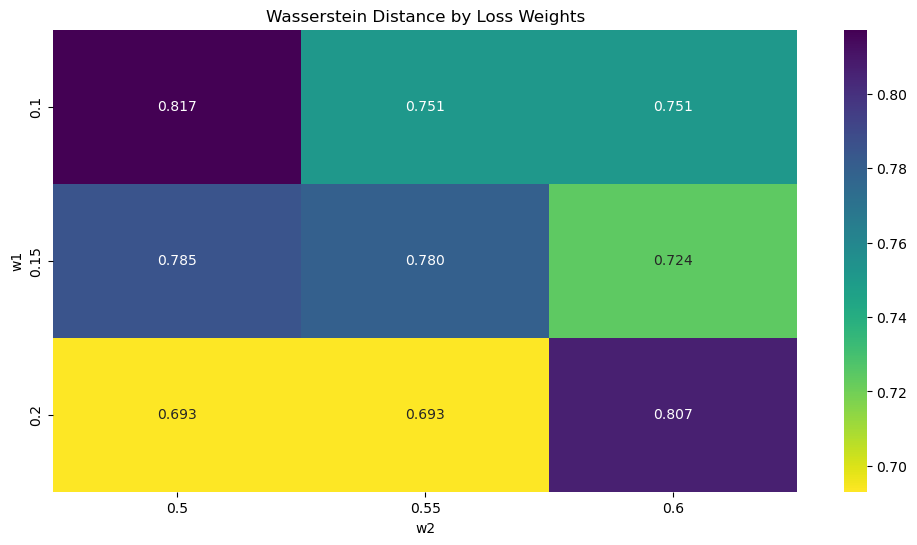


Best configuration:
w1             0.200000
w2             0.550000
lambda_eng     0.150000
lr             0.001000
wasserstein    0.563277
Name: 22, dtype: float64


In [12]:
# Save and visualize results
results_df = pd.DataFrame(results)
results_df.to_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\tuning_results.csv", index=False)

plt.figure(figsize=(12,6))
sns.heatmap(pd.pivot_table(results_df, values='wasserstein', index='w1', columns='w2'), 
            annot=True, fmt=".3f", cmap="viridis_r")
plt.title("Wasserstein Distance by Loss Weights")
plt.show()

print("\nBest configuration:")
print(results_df.loc[results_df['wasserstein'].idxmin()])


Verifying best configuration with multiple trials:

=== Trial 1/3 ===
Epoch 1/150 Loss: 1.0770
Epoch 2/150 Loss: 0.7823
Epoch 3/150 Loss: 0.7342
Epoch 4/150 Loss: 0.7000
Epoch 5/150 Loss: 0.6764
Epoch 6/150 Loss: 0.6601
Epoch 7/150 Loss: 0.6346
Epoch 8/150 Loss: 0.6102
Epoch 9/150 Loss: 0.5916
Epoch 10/150 Loss: 0.5733
Epoch 11/150 Loss: 0.5498
Epoch 12/150 Loss: 0.5417
Epoch 13/150 Loss: 0.5349
Epoch 14/150 Loss: 0.5275
Epoch 15/150 Loss: 0.5259
Epoch 16/150 Loss: 0.5142
Epoch 17/150 Loss: 0.4913
Epoch 18/150 Loss: 0.4892
Epoch 19/150 Loss: 0.4909
Epoch 20/150 Loss: 0.4750
Epoch 21/150 Loss: 0.4621
Epoch 22/150 Loss: 0.4718
Epoch 23/150 Loss: 0.4563
Epoch 24/150 Loss: 0.4545
Epoch 25/150 Loss: 0.4596
Epoch 26/150 Loss: 0.4439
Epoch 27/150 Loss: 0.4456
Epoch 28/150 Loss: 0.4357
Epoch 29/150 Loss: 0.4339
Epoch 30/150 Loss: 0.4366
Epoch 31/150 Loss: 0.4203
Epoch 32/150 Loss: 0.4176
Epoch 33/150 Loss: 0.4137
Epoch 34/150 Loss: 0.4114
Epoch 35/150 Loss: 0.4061
Epoch 36/150 Loss: 0.4122
Ep

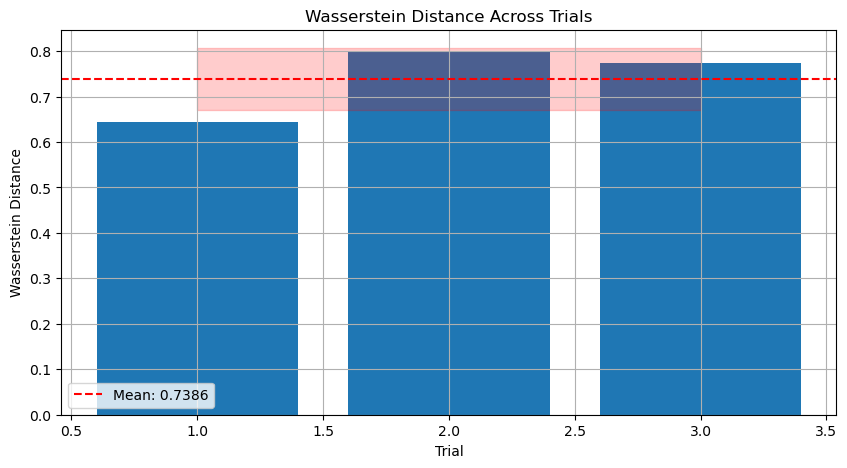

In [18]:
#############################################
# Step 1: Add Seed Control
#############################################
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#############################################
# Step 2: Run Multiple Trials
#############################################
# Best configuration from previous tuning
best_config = {
    'w1': 0.2,
    'w2': 0.55,
    'lambda_eng': 0.15,
    'lr': 0.001
}

num_trials = 3
trial_results = []

print("\nVerifying best configuration with multiple trials:")
for trial in range(num_trials):
    set_seed(42 + trial)  # Different seed for each trial
    print(f"\n=== Trial {trial + 1}/{num_trials} ===")
    
    # Create dataset and loader
    train_dataset = FraudDataset(X_train_num, X_train_cat)
    train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
    
    # Train model and get trained model back
    trained_model = train_model(best_config, train_loader)
    ws_dist = evaluate_model(trained_model)
    
    trial_results.append({
        'trial': trial + 1,
        'wasserstein': ws_dist
    })
    
    print(f"\nTrial {trial + 1} Results:")
    print(f"  Wasserstein: {ws_dist:.4f}")

# Calculate statistics
wasserstein_scores = [r['wasserstein'] for r in trial_results]
mean_wasserstein = np.mean(wasserstein_scores)
std_wasserstein = np.std(wasserstein_scores)

print("\nOverall Results:")
print(f"Mean Wasserstein: {mean_wasserstein:.4f} ± {std_wasserstein:.4f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.bar(range(1, num_trials + 1), wasserstein_scores)
plt.axhline(y=mean_wasserstein, color='r', linestyle='--', 
           label=f'Mean: {mean_wasserstein:.4f}')
plt.fill_between(range(1, num_trials + 1), 
                 mean_wasserstein - std_wasserstein,
                 mean_wasserstein + std_wasserstein,
                 alpha=0.2, color='r')
plt.xlabel('Trial')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance Across Trials')
plt.legend()
plt.grid(True)
plt.show()